# Deploying and publishing packages

## Topic learning objectives

By the end of this topic, students should be able to:

1. Define continuous deployment and argue the costs and benefits of continuous deployment
2. Explain semantic versioning, and define what constitutes patch, minor, major and breaking changes
3. Use continuous deployment (e.g., GitHub Actions) to automate deployment of software packages, or components of software packages (e.g., documentation)
4. Publish software packages to development and production package repositories (e.g., GitHub and CRAN)

## Continous Deployment (CD)

Defined as the practice of automating the deployment of software that has successfully run through your test-suite.

For example, upon merging a pull request to master, an automation process builds the Python package and publishes to PyPI without further human intervention. 

### Why use CD?

- little to no effort in deploying new version of the software allows new features to be rolled out quickly and frequently
- also allows for quick implementation and release of bug fixes
- deployment can be done by many contributors, not just one or two people with a high level of Software Engineering expertise

### Why use CD?

Perhaps this story is more convincing:

*The company, let’s call them ABC Corp, had 16 instances of the same software, each as a different white label hosted on separate Linux machines in their data center. What I ended up watching (for 3 hours) was how the client remotely connected to each machine individually and did a “capistrano deploy”. For those unfamiliar, Capistrano is essentially a scripting tool which allows for remote execution of various tasks. The deployment process involved running multiple commands on each machine and then doing manual testing to make sure it worked.*

*The best part was that this developer and one other were the only two in the whole company who knew how to run the deployment, meaning they were forbidden from going on vacation at the same time. And if one of them was sick, the other had the responsibility all for themselves. This deployment process was done once every two weeks.*

[*Source*](https://levelup.gitconnected.com/heres-why-continuous-integration-and-deployment-is-so-important-to-the-software-development-c0caeead5881)*: Tylor Borgeson*

Infrequent & manual deployment makes me feel like this when it comes time to do it:

![](https://media.giphy.com/media/bEVKYB487Lqxy/giphy.gif)

*and so it can become a viscious cycle of delaying deployment because its hard, and then making it harder to do deployment because a lot of changes have been made since the last deployment...*

So to avoid this, we are going to do continuous deployment when we can! And where we can't, we will automate as much as we can up until the point where we need to manually step in.

## Examples of CD being used for data science

- [Python packages](https://py-pkgs.org/08-ci-cd#setting-up-continuous-deployment) (but not R, more on this later...)

- Package documentation (e.g., [`pkgdown` websites](https://pkgdown.r-lib.org/) for R, [ReadtheDocs](https://py-pkgs.org/06-documentation#hosting-documentation-online) websites for Python)

- Books and websites (e.g., [`jupyter-book`](https://jupyterbook.org/intro.html), [`bookdown`](https://bookdown.org/), [`distill` websites](https://pkgs.rstudio.com/distill/index.html), etc)

## Conditionals for when to run the job

We only want our `cd` job to run if certain conditions are true, these are:

1. if the `ci` job passes

2. if this is a commit to the `main` branch

We can accomplish this in our `cd` job be writing a conditional using the `needs` and `if` keywords at the top of the job, right after we set the permissions:

```
cd:
    permissions:
      id-token: write
      contents: write

    # Only run this job if the "ci" job passes
    needs: ci

    # Only run this job if new work is pushed to "main"
    if: github.event_name == 'push' && github.ref == 'refs/heads/main'
```

### Exercise: read the `cd` job of [`ci-cd.yml`](https://github.com/py-pkgs/py-pkgs-cookiecutter/blob/main/%7B%7B%20cookiecutter.__package_slug%20%7D%7D/.github/workflows/ci-cd.yml)

To make sure we understand what is happening in our workflow that performs CD, let's convert each **step** to a human-readable explanation:

1. Sets up Python on the runner

2. Checkout our repository files from GitHub and put them on the runner

3. ...

4. ...

5. ...

6. ...

7. ...

> Note: I filled in the steps we went over last class, so you can just fill in the new stuff

### How can we automate version bumping?

Let's look at the first step that works towards accomplishing this:

```
      - name: Use Python Semantic Release to prepare release
        id: release
        uses: python-semantic-release/python-semantic-release@v8.3.0
        with:
          github_token: ${{ secrets.GITHUB_TOKEN }}
```

[Python semantic-release](https://python-semantic-release.readthedocs.io/en/latest/) is a Python tool which parses commit messages looking for keywords to indicate how to bump the version. It bumps the version in the `pyproject.toml` file.

To understand how it works so that we can use it, we need to understand **semantic versioning** and how to write **conventional commit** messages.

Let's unpack each of these on its own.

## Semantic versioning

- When we make changes and publish new versions of our packages, we should tag these with a version number so that we and others can view and use older versions of the package if needed. 

- These version numbers should also communicate something about how the underlying code has changed from one version to the next. 

- Semantic versioning is an agreed upon "code" by developers that gives meaning to version number changes, so developers and users can make meaningful predictions about how code changes between versions from looking solely at the version numbers.

- Semantic versioning assumes version 1.0.0 defines the API, and the changes going forward use that as a starting reference.

## Semantic versioning

Given a version number `MAJOR.MINOR.PATCH` (e.g., `2.3.1`), increment the:

- MAJOR version when you make incompatible API changes (often called breaking changes 💥) 

- MINOR version when you add functionality in a backwards compatible manner ✨↩️

- PATCH version when you make backwards compatible bug fixes 🐞

*Source: https://semver.org/*

### Semantic versioning case study

**Case 1:** In June 2009, Python bumped versions from 3.0.1, some changes in the new release included:
- Addition of an ordered dictionary type
- A pure Python reference implementation of the import statement
- New syntax for nested with statements

**Case 2:** In Dec 2017, Python bumped versions from 3.6.3, some changes in the new release included:

- Fixed several issues in printing tracebacks (`PyTraceBack_Print()`).
- Fix the interactive interpreter looping endlessly when no memory.
- Fixed an assertion failure in Python parser in case of a bad `unicodedata.normalize()`

**Case 3:** In Feb 2008, Python bumped versions from 2.7.17, some changes in the new release included:
- `print` became a function
- integer division resulted in creation of a float, instead of an integer
- Some well-known APIs no longer returned lists (e.g., `dict.keys`, `dict.values`, `map`)

### Exercise: name that semantic version release

Reading the three cases posted above, think about whether each should be a major, minor or patch version bump. Answer the chat when prompted.

## Conventional commit messages

[Python Semantic Release](https://python-semantic-release.readthedocs.io/en/latest/) by default uses a parser that works on the conventional (or Angular) commit message style, which is:

```
<type>(optional scope): succinct description of the change

(optional body: the motivation for the change and contrast this with previous behavior)

(optional footer: note BREAKING CHANGES here, as well as any issues to be closed)
```


How to affect semantic versioning with conventional commit messages:
- a commit with the type `fix` leads to a patch version bump
- a commit with the type `feat` leads to a minor version bump
- a commit with a body or footer that starts with `BREAKING CHANGE:` - these can be of any type (Note: currently Python Semantic release is broken for detecting these on commits with Windows line endings, wich the GitHub pen tool commits also use. The workaround fix is to use `!` after `feat`, for example: `feat!: This describes the new feature and breaking changes` in addition to `BREAKING CHANGES: ...` in the footer.)

> Note - commit types other than `fix` and `feat` are allowed. Recommeneded ones include `docs`, `style`, `refactor`, `test`, `ci` and [others](https://github.com/angular/angular/blob/master/CONTRIBUTING.md#type). However, only `fix` and `feat` result in version bumps using Python Semantic Release.

### An example of a conventional commit message

```
git commit -m "feat(function_x): added the ability to initialize a project even if a pyproject.toml file exists"
```

What kind of version bump would this result in?

### Another example of a conventional commit message

```
git commit -m "feat!: change to use of `%>%` to add new layers to ggplot objects

BREAKING CHANGE: `+` operator will no longer work for adding new layers to ggplot objects after this release"
```

What kind of version bump would this result in?

### Some practical notes for usage in your packages:

1. You must add the following to the tool section of your `pyproject.toml` file for this to work (note: the `pypkgs-cookiecutter` adds this table if you choose to add `ci-cd` when you set it up):

    ```
    [tool.semantic_release]
    version_toml = [
        "pyproject.toml:tool.poetry.version",
    ]                                                    # version location
    branch = "main"                                      # branch to make releases of
    changelog_file = "CHANGELOG.md"                      # changelog file
    build_command = "pip install poetry && poetry build" # build dists
    ```
    
2. Versions will **not** be bumped if conventional commits are not used.

### Some practical notes for usage in your packages:


1. Automated version bumping can only work (as currently implemented in our cookiecutter) with versions in the `pyproject.toml` metadata (line 3). If you add a version elsewhere, it will not get bumped unless you specify the location the the `[tool.semantic_release]` table in `pyproject.toml`.

2. If you have been working with main branch protection, you will need to change something to use `ci.yml` work for continuous deployment. The reason for this, is that this workflow (which bumps versions and deploy the package) is triggered to run **after** the pull request is merged to main. Therefore, when we bump the versions in the `pyproject.toml` file we need to push these changes to the main branch - however this is problematic given that we have set-up main branch protection!

What are we to do about #2?

#### Solution 1: 

Remove main branch protection. This is not the most idealistic solution, however it is a simple and practical one.

#### Possible solution 2: 

(I say possible because this has yet to be formally documented by PSR, and is still just reported in an issue: <https://github.com/python-semantic-release/python-semantic-release/issues/311>. I have tested it and it works for me, see example here: <https://github.com/ttimbers/pycounts_tt_2024/blob/main/.github/workflows/ci-cd.yml>)

1. Create a new GitHub PAT (see [these docs](https://docs.github.com/en/authentication/keeping-your-account-and-data-secure/creating-a-personal-access-token)) with the [repo](https://docs.github.com/en/developers/apps/building-oauth-apps/scopes-for-oauth-apps#available-scopes) scope.

2. Under **"Secrets"**, click on **"Settings and variables"** > **"Actions"**, and then under **"Repository secrets"** click **"New repository secret"** to create a new repository secret named `RELEASE_TOKEN` and the new GitHub PAT with repo scope as its value.

3. Edit the to `cd` job steps shown below (from `ci-cd.yml`) use this token:

```
...
    - uses: actions/checkout@v3
      with:
        fetch-depth: 0
        token: ${{ secrets.RELEASE_TOKEN }}
...

    - name: Use Python Semantic Release to prepare release
      id: release
      uses: python-semantic-release/python-semantic-release@v8.3.0
      with:
        github_token: ${{ secrets.RELEASE_TOKEN }}
...
```

### Demo of Continous Deployment!

- <https://github.com/ttimbers/pycounts_tt_2024>

### What about CD with R packages

- This is not a common practice (yet!). One reason for this could be that CRAN has a policy where they only want to see updates every 1-2 months.

- Semantic versioning is used in Tidyverse R packages, but creating versions is done manually

## Publishing your R package

### Level 1: publishing on GitHub

For this course, we will only publish your package on GitHub, not CRAN. For this to work, you need to push your package code to GitHub and provide users these instructions to download, build and install your package:

```
# install.packages("devtools")
devtools::install_github("ttimbers/convertempr")
```

This is where almost all R packages start out publishing, and continue publishing development versions between releases.

## Level 2: publishing on CRAN

- CRAN (founded in 1997) stands for the "Comprehensive R Archive Network"

- it is a collection of sites which host identical copies of:
    - R distribution(s)
    - the contributed extensions (*i.e.,* packages)
    - documentation for R
    - binaries (i.e., packages)
- as of 2012, there were 85 official ‘daily’ mirrors

 *Source: Hornik, K (2012). The Comprehensive R Archive Network. Wiley interdisciplinary reviews. Computational statistics. 4(4): 394-398. [doi:10.1002/wics.1212](https://onlinelibrary-wiley-com.ezproxy.library.ubc.ca/doi/full/10.1002/wics.1212)*
 
> ### Binary vs source distributions, what's the difference?
> 
> Binary distributions are pre-compiled (computer readable), whereas source distributions have to be compiled before they are installed.
> 
> Precompiled binaries are often different for each operating system (e.g., Windows vs Mac)

### Number of packages hosted by CRAN over history

<img src="https://www.researchgate.net/publication/333159083/figure/fig1/AS:759374838517760@1558060478678/Number-of-R-packages-contributed-to-the-Comprehensive-R-Archive-Network-CRAN-as-a.png" width=800>

*Source: ["Reproducibility and Replicability in a Fast-Paced Methodological World"](https://journals.sagepub.com/doi/10.1177/2515245919847421) by Sacha Epskamp*

### What does it mean to be a CRAN package:

**A stamp of authenticity:**
- passed quality control of the `check` utility

**Ease of installation:**
- can be installed by users via `install.packages` (it's actually the default!)
- binaries available for Windows & Mac OS's

**Discoverability:**
- listed as a package on CRAN 

**HOWEVER** - CRAN makes no assertions about the package's usability, or the efficiency and correctness of the computations it performs

### How to submit a package to CRAN

1. Pick a version number.
2. Run and document `R CMD check`.
3. Check that you’re aligned with CRAN policies.
4. Update README.md and NEWS.md.
5. Submit the package to CRAN.
6. Prepare for the next version by updating version numbers.
7. Publicise the new version.

*Source: [Chapter 18 Releasing a package](https://r-pkgs.org/release.html) - R packages book by Hadley Wickham & Jenny Bryan*

### Notes on submitting to CRAN

- CRAN is staffed by volunteers, all of whom have other full-time jobs
- A typical week has over 100 submissions and only three volunteers to process them all. 
- The less work you make for them the more likely you are to have a pleasant submission experience... 

### Notes on submitting to CRAN (cont'd)

Technical things:

- Your package must pass `R CMD check` with the current development version of R (R-devel)
- it must work on at least two platforms (CRAN uses the following 4 platforms: Windows, Mac OS X, Linux and Solaris) - use GitHub Actions to ensure this before submitting to CRAN!

*If you decide to submit a package to CRAN follow the detailed instructions in [Chapter 18 Releasing a package](https://r-pkgs.org/release.html) fromt the R packages book by Hadley Wickham & Jenny Bryan to do so. If you submit your package to rOpenSci, they will help you get everything in order for submission to CRAN as well!*

CRAN policies: <https://cran.r-project.org/web/packages/policies.html>

Most common problems (from the R packages book):

- The maintainer’s e-mail address must be stable, if they can’t get in touch with you they will remove your package from CRAN. 

- You must have clearly identified the copyright holders in DESCRIPTION: if you have included external source code, you must ensure that the license is compatible.

- Do not make external changes without explicit user permission. Don’t write to the file system, change options, install packages, quit R, send information over the internet, open external software, etc.

- Do not submit updates too frequently. The policy suggests a new version once every 1-2 months at most.

### If your submission fails:

Read section 18.6.1 "On failure" from  [Chapter 18 Releasing a package](https://r-pkgs.org/release.html) - R packages book by Hadley Wickham & Jenny Bryan*

TL;DR - Breathe, don't argue, fix what is needed and re-submit.

## Publishing your Python package

### Level 1: GitHub

Packages can be installed from GitHub via `pip`:

```
pip install git+https://github.com/USERNAME/REPOSITORY.git
```

### Level 2: PyPI

Packages can be installed from `PyPI` via:

```
pip install PACKAGE_NAME
```

- should be pronounced like "pie pea eye"
- also known as the Cheese Shop (a reference to the Monty Python's Flying Circus sketch "Cheese Shop")

> Because level 2 is so easy, it is the most commonly used method.

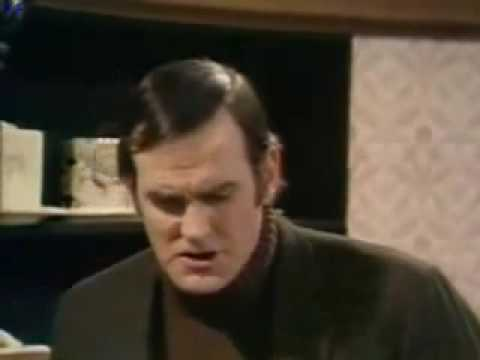

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('zB8pbUW5n1g')

Don't get the joke? I didn't either without historical context. When PyPI was first launched it didn't have many Python packages on it - similar to a cheese shop with no cheese 😆

### the Cheese Shop (er, PyPI)

- PyPI (founded in 2002) stands for the "Python Package Index"

-  hosts Python packages of two different forms:
    - sdists (source distributions)
    - precompiled "wheels (binaries)
- heavily cached and distributed
- currently contains > 9000 projects

### Number of packages hosted by PyPI over history

<img src="https://www.researchgate.net/profile/Marat_Valiev2/publication/328595587/figure/fig1/AS:687258193633280@1540866530197/Number-of-new-PyPI-packages-per-month.png" width=800>

*Source: ["Ecosystem-level determinants of sustained activity in open-source projects: a case study of the PyPI ecosystem"](https://dl.acm.org/doi/10.1145/3236024.3236062) by  Marat Valiev, Bogdan Vasilescu & James Herbsleb*

### What does it mean to be a PyPI package:

**Ease of installation:**
- can be installed by users via `pip install` (it's actually the default!)
- universal binaries available for packages that are written solely in Python

**Discoverability:**
- listed as a package on PyPI

HOWEVER, there is no required check for your package is required to pass... As long as you can bundle it as something that PyPI recognizes as an sdist or wheels then it can go on PyPI... This allows the process to be fully automated, but QC is lower than it is for CRAN.

### How to submit a package to PyPI

See the ["How to package a Python"](https://py-pkgs.org/03-how-to-package-a-python#) chapter of the *Python Packages* book.


### Points for discussion 

- Is one model better or worse? 

- Importance & complimentarity of organizations like rOpenSci & pyOpenSci with CRAN and PyPI, respecitively

## Peer review facilitates package publishing

### [rOpenSci](https://ropensci.org/) 

#### aims and goals:

rOpenSci fosters a culture that values open and reproducible research using shared data and reusable software.

We do this by:
- Creating technical infrastructure in the form of carefully vetted, staff- and community-contributed R software tools that lower barriers to working with scientific data sources on the web

- Creating social infrastructure through a welcoming and diverse community

- Making the right data, tools and best practices more discoverable

- Building capacity of software users and developers and fostering a sense of pride in their work

- Promoting advocacy for a culture of data sharing and reusable software.

*Source: <https://ropensci.org/about/>*


### rOpenSci's open peer review process

- Authors submit complete R packages to rOpenSci.

- Editors check that packages fit into rOpenSci's scope, run a series of automated tests to ensure a baseline of code quality and completeness, and then assign two independent reviewers.

- Reviewers comment on usability, quality, and style of software code as well as documentation. 

- Authors make changes in response.

- Once reviewers are satisfied with the updates, the package receives a badge of approval and joins rOpenSci's suite of approved pacakges.

- Happens openly, and publicly on GitHub in issues.

- Process is quite iterative and fast. After reviewers post a first round of extensive reviews, authors and reviewers chat in an informal back-and-forth, only lightly moderated by an editor. 

*Source: <https://numfocus.org/blog/how-ropensci-uses-code-review-to-promote-reproducible-science>*

###  rOpenSci's Guidance and Standards

What aspects of a package are reviewed? 

- high-level best practices:
    - is the code reusable (e.g. follow the DRY principle)?
    - are sufficient edge cases tested?
    - etc
    
- low-level standards:
    - are naming conventions for functions followed?
    - did they make the best choices of dependencies for the package's intended tasks?
    - etc
    
*Source: <https://numfocus.org/blog/how-ropensci-uses-code-review-to-promote-reproducible-science>*

###  rOpenSci's Review Guidebook

- <https://devguide.ropensci.org/>

### rOpenSci-reviewed packages:

- <https://ropensci.org/packages/>

### Let's look at an rOpenSci review!

All packages currently under review: <https://github.com/ropensci/software-review/issues>

- [Review of tidypmc](https://github.com/ropensci/software-review/issues/290)


### What do you get for having your package reviewed by rOpenSci?

- valuable feedback from the knowledgeable editors and reviewers
- help with package maintenance and submission of your package to CRAN
- promotion of your package on their website, blog and social media
- packages that have a short accompanying paper can be automatically submitted to [JOSS](https://joss.theoj.org/) and fast-tracked for publication.

## [pyOpenSci](https://www.pyopensci.org/)

- A new organization, modelled after rOpenSci
- scope is Python packages
- First package submitted to pyOpenSci was in May 2019

### Semantic versioning case study - answers

In 2008, Python bumped versions from 2.7.17 to 3.0.0. Some changes in the 3.0.0 release included:
- `print` became a function
- integer division resulted in creation of a float, instead of an integer
- Some well-known APIs no longer returned lists (e.g., `dict.keys`, `dict.values`, `map`)
- and many more (see [here](https://docs.python.org/3.0/whatsnew/3.0.html) if interested)

[*Source*](https://docs.python.org/3.0/whatsnew/3.0.html)

In 2009, Python bumped versions from 3.0.1 to 3.1.0. Some changes in the 3.1.0 release included:
- Addition of an ordered dictionary type
- A pure Python reference implementation of the import statement
- New syntax for nested with statements

[*Source*](https://www.python.org/download/releases/3.1/)

In 2017, Python bumped versions from 3.6.3 to 3.6.4. Some changes in the 3.6.4 release included:

- Fixed several issues in printing tracebacks (`PyTraceBack_Print()`).
- Fix the interactive interpreter looping endlessly when no memory.
- Fixed an assertion failure in Python parser in case of a bad `unicodedata.normalize()`

[*Source*](https://docs.python.org/3.6/whatsnew/changelog.html#python-3-6-4-final)